# An Analysis of Lending Club Loan Data

Requirements: wget, unzip, pandas, numpy, sklearn, matplotlib

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import os.path

In [25]:
%matplotlib inline

In [26]:
prediction_variable = "int_rate"

extraneous_cols = ["out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries",
				   "collection_recovery_fee", "next_pymnt_d", "last_pymnt_d", "last_pymnt_amnt", "last_credit_pull_d", "acc_now_delinq",
				   "sub_grade", "issue_d", "initial_list_status", "loan_amnt", "funded_amnt_inv", "emp_title", "pymnt_plan", "zip_code", "title",
                   "addr_state", "earliest_cr_line", "loan_status", "hardship_flag", "application_type", "installment"]

important_cols = ["annual_inc", "verification_status", "term", "home_ownership", "emp_length",
				  "funded_amnt", "int_rate"] #add back delinq_2yrs, dti, inq_last_6mths

data_files = ["LoanStats_2016Q1.csv",
              "LoanStats_2016Q2.csv",
              "LoanStats_2016Q3.csv",
              "LoanStats_2016Q4.csv",
              "LoanStats_2017Q1.csv"]

In [27]:
for filename in data_files:
    if not os.path.isfile(("data/" + filename)):
        url = "https://resources.lendingclub.com/" + filename + ".zip"
        final_relative_filepath = "data/" + filename + ".zip"
        
        !wget -P data/ $url
        !unzip $final_relative_filepath -d data/
        !rm $final_relative_filepath

mkdir: data: File exists


In [28]:
dfs = []
for file in ["data/" + filename for filename in data_files]:
    with open(file, "r") as f:
        first_row = next(f)
        # check if "Notes offered" header is present
        if first_row.startswith("Notes offered"):
            # remove top header related to "Notes offered" from CSV file
            with open(file, "r") as original, open((file + "1"), "w") as updated:
                next(original)
                for line in original:
                    updated.write(line)
            os.remove(file)
            os.rename((file + "1"), file)

    # low_memory option gets rid of annoying warning
    # don't include extraneous_cols
    dfs.append(pd.read_csv(file, low_memory = False, usecols = lambda col : col not in extraneous_cols))
lc = pd.concat(dfs)

In [29]:
lc.reset_index(drop = True, inplace = True)

In [30]:
nunique = lc.apply(pd.Series.nunique)
lc.drop(nunique[nunique <= 1].index, axis=1, inplace=True)

In [31]:
coverage = lc.apply(lambda col : col.isnull().sum() / len(col))
lc.drop(coverage[coverage >= 0.5].index, axis=1, inplace=True)

In [32]:
lc = lc.dropna(how = "any", subset = important_cols)

In [33]:
# convert int rate string to float
lc["int_rate"] = pd.Series(lc["int_rate"]).str.replace("%", "").astype(float)

In [34]:
lc["revol_util"] = pd.Series(lc["revol_util"]).str.replace("%", "").astype(float)

In [35]:
lc["term"] = lc["term"].replace("[^0-9]+", "", regex=True).fillna(0).astype(int)

In [36]:
lc["emp_length"].replace("n/a", "0", inplace=True)
lc["emp_length"] = lc["emp_length"].replace("[^0-9]+", "", regex=True).fillna(0).astype(int)

In [37]:
lc = lc.apply(lambda x: x.fillna(x.median()) if x.dtype.kind in "biufc" else x)

In [38]:
lc = lc[lc["term"] == 36]

In [39]:
lc = lc[lc["dti"] < 100] # get rid of junk data where dti > 100

In [40]:
cor = lc.corr()
cor.loc[:, :] = np.tril(cor, k=-1)
cor = cor.stack()
cor[(cor > 0.7) | (cor < -0.7)]

total_acc                   open_acc                0.727237
open_il_24m                 open_il_12m             0.758616
open_rv_24m                 open_rv_12m             0.777504
total_rev_hi_lim            revol_bal               0.830151
acc_open_past_24mths        open_rv_24m             0.851966
avg_cur_bal                 tot_cur_bal             0.835052
bc_util                     revol_util              0.851376
num_actv_rev_tl             num_actv_bc_tl          0.817753
num_bc_sats                 num_actv_bc_tl          0.844293
num_bc_tl                   num_bc_sats             0.763932
num_op_rev_tl               open_acc                0.833218
                            num_actv_rev_tl         0.801890
                            num_bc_sats             0.752132
num_rev_accts               total_acc               0.760663
                            num_bc_tl               0.836718
                            num_op_rev_tl           0.805217
num_rev_tl_bal_gt_0     

In [41]:
#create dummy variables for categorical variables
lc = pd.get_dummies(lc, columns=["home_ownership", "verification_status", "purpose"])

In [42]:
print("Dimensions: ", lc.shape)
lc.head(5)

Dimensions:  (395722, 89)


,funded_amnt,term,int_rate,grade,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
2,35000.0,36,10.75,B,10,70000.0,17.86,0.0,0.0,31.0,...,0,0,0,0,0,0,0,0,0,0
3,8825.0,36,13.67,C,1,32000.0,21.49,0.0,0.0,45.0,...,0,0,0,0,0,0,0,0,0,0
4,10000.0,36,11.47,B,6,33000.0,21.45,0.0,0.0,30.0,...,0,0,0,0,0,0,0,0,0,0
5,14000.0,36,5.32,A,10,240000.0,12.31,1.0,0.0,12.0,...,0,0,0,0,0,0,0,0,0,0
6,16000.0,36,12.99,C,1,50000.0,38.32,0.0,0.0,50.0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# reorder columns so variable being predicted is in first column
cols = lc.columns.tolist()
cols.insert(0, cols.pop(cols.index(prediction_variable)))
cols.insert(1, cols.pop(cols.index("grade"))) # put the grade column in between
lc = lc.loc[:, cols]

In [21]:
data = lc.values
X = data[:, 2:] # skip the grade column
y = data[:, 0]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)
rf_tt = RandomForestRegressor(n_estimators = 100, n_jobs = -1)
rf_tt.fit(X_train, y_train)
print("Training accuracy: {:.2f}".format(rf_tt.score(X_train, y_train)))
print("Generalization accuracy: {:.2f}".format(rf_tt.score(X_test, y_test)))

In [ ]:
def plot_feature_importances (model):
    n_features = len(lc.columns.tolist()[1:])
    plt.figure(figsize=(20, 20))
    plt.barh(range(n_features), model.feature_importances_, align="center")
    plt.yticks(np.arange(n_features), lc.columns.tolist()[1:])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(rf_tt)

In [ ]:
def plot_results_scatter (y_predict, y_test):
    plt.scatter(y_test, y_predict)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    
plot_results_scatter(rf_tt.predict(X_test), y_test)

In [ ]:
rf_500est = RandomForestRegressor(n_estimators = 500, n_jobs = -1)
rf_500est.fit(X_train, y_train)
print("Training accuracy: {:.2f}".format(rf_500est.score(X_train, y_train)))
print("Generalization accuracy: {:.2f}".format(rf_500est.score(X_test, y_test)))

In [ ]:
# try cross validating to see if the overfitting is a persistent issue

rf = RandomForestRegressor(n_estimators=100)
print("Cross-validation scores:\n{}".format(cross_val_score(rf, X, y, cv=5, n_jobs=-1)))

In [ ]:
rf_lower_max_features = RandomForestRegressor(n_estimators = 100, max_features = 1, n_jobs = -1)
rf_lower_max_features.fit(X_train, y_train)
print("Training accuracy: {:.2f}".format(rf_lower_max_features.score(X_train, y_train)))
print("Generalization accuracy: {:.2f}".format(rf_lower_max_features.score(X_test, y_test)))

In [ ]:
rf_higher_min_samples_leaf = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 10, n_jobs = -1)
rf_higher_min_samples_leaf.fit(X_train, y_train)
print("Training accuracy: {:.2f}".format(rf_higher_min_samples_leaf.score(X_train, y_train)))
print("Generalization accuracy: {:.2f}".format(rf_higher_min_samples_leaf.score(X_test, y_test)))

In [ ]:
rf_higher_min_samples_leaf1 = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 20, n_jobs = -1)
rf_higher_min_samples_leaf1.fit(X_train, y_train)
print("Training accuracy: {:.2f}".format(rf_higher_min_samples_leaf1.score(X_train, y_train)))
print("Generalization accuracy: {:.2f}".format(rf_higher_min_samples_leaf1.score(X_test, y_test)))

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.neural_network import MLPRegressor

initial_nn = MLPRegressor()
initial_nn.fit(X_train_scaled, y_train)
print("Training accuracy: {:.2f}".format(initial_nn.score(X_train_scaled, y_train)))
print("Generalization accuracy: {:.2f}".format(initial_nn.score(X_test_scaled, y_test)))

In [ ]:
nn_more_hidden_layers = MLPRegressor(hidden_layer_sizes = [100, 100])
nn_more_hidden_layers.fit(X_train_scaled, y_train)
print("Training accuracy: {:.2f}".format(nn_more_hidden_layers.score(X_train_scaled, y_train)))
print("Generalization accuracy: {:.2f}".format(nn_more_hidden_layers.score(X_test_scaled, y_test)))

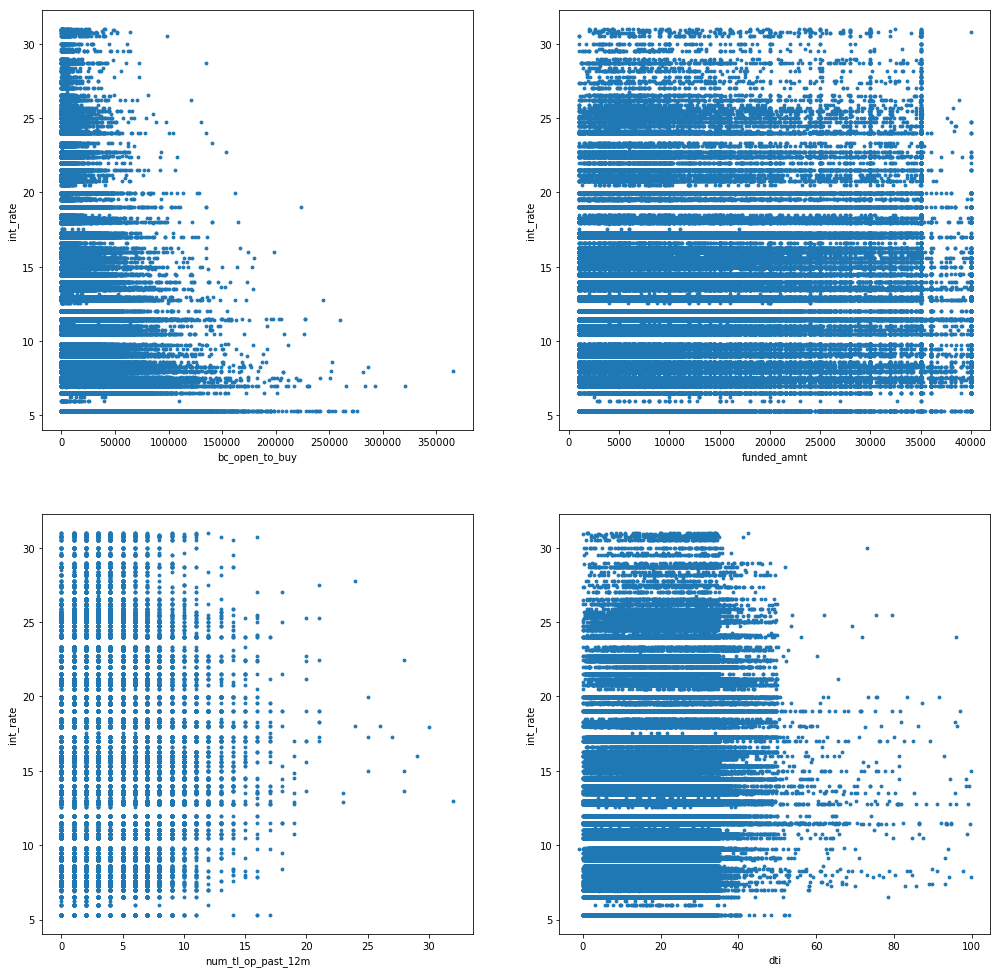

In [22]:
def plot_scatter (ax, variable):
    ax.scatter(lc[variable].values, lc["int_rate"].values, s=8)
    ax.set_xlabel(variable)
    ax.set_ylabel("int_rate")

fig = plt.figure(1, figsize=(17,17))

ax = fig.add_subplot(221)
plot_scatter(ax, "bc_open_to_buy")

ax2 = fig.add_subplot(222)
plot_scatter(ax2, "funded_amnt")

ax3 = fig.add_subplot(223)
plot_scatter(ax3, "num_tl_op_past_12m")

ax4 = fig.add_subplot(224)
plot_scatter(ax4, "dti")

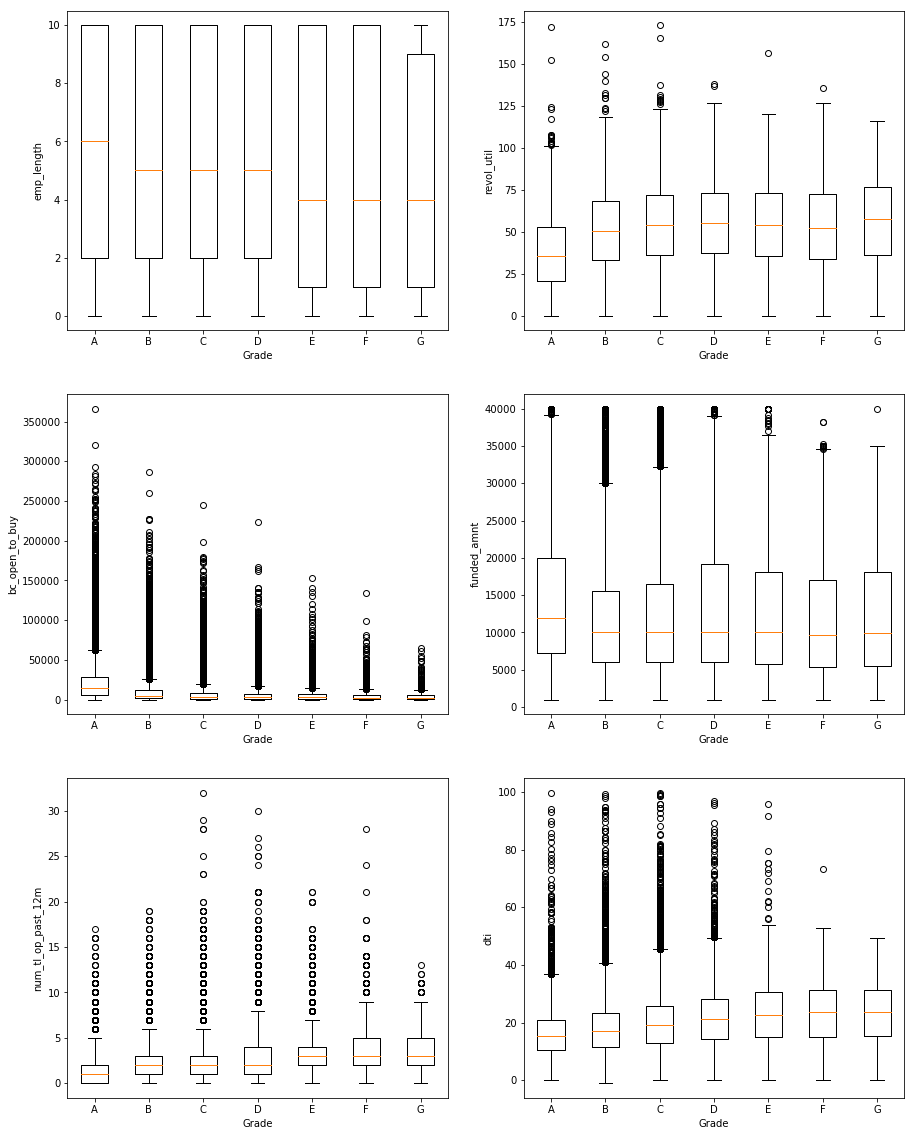

In [23]:
def plot_boxplots (ax, variable):
    ax.boxplot([lc[lc["grade"] == grade][variable].values for grade in sorted(lc["grade"].unique())])
    ax.set_xticklabels(sorted(lc["grade"].unique()))
    ax.set_xlabel("Grade")
    ax.set_ylabel(variable)

fig = plt.figure(2, figsize=(15,20))

ax = fig.add_subplot(321)
plot_boxplots(ax, "emp_length")

ax2 = fig.add_subplot(322)
plot_boxplots(ax2, "revol_util")

ax3 = fig.add_subplot(323)
plot_boxplots(ax3, "bc_open_to_buy")

ax4 = fig.add_subplot(324)
plot_boxplots(ax4, "funded_amnt")

ax5 = fig.add_subplot(325)
plot_boxplots(ax5, "num_tl_op_past_12m")

ax6 = fig.add_subplot(326)
plot_boxplots(ax6, "dti")